# A look under the hood for least squares regresion 

we're going to blow through the first steps from floor0plate_and_ratios with no explanation. if you want more explanation about this, go to that workbook

In [13]:
import pandas as pd
import numpy as np
import numpy.linalg as la
df = pd.DataFrame([['mc_auburn', 'mc', 'ms', 24, 14, 21.5, 16, 21.5, 177.5, 90.6667, 15405.5]
                   ,['mc_milgard', 'mc', 'ms', 24, 15.25, 22.5, 15.25, 22.5, 217.5, 102, 22991]
                   ,['mc_rainier', 'mc', 'ms', 18, 15.25, 22, 16.6875, 22, 130, 129, 16138] # these square floors are defo having an effect
                   ,['mc_rainier', 'mc', 'nicu', 24, 15.25, 14, 15.25, 14, 130, 129, 16138]
                   ,['mc_rainier', 'mc', 'ldrp', 16, 15.25, 22, 23.4167, 22, 130, 129, 16138]
                   ,['swedish_nw_tower', 'swedish', 'icu', 48, 16, 24, 19, 24, 451.875, 100.5, 43852]
                   ,['swedish_nw_tower', 'swedish', 'ms', 48, 16, 24, 19, 24, 451.875, 100.5, 43852]
                   ,['swedish_issaquah', 'swedish', 'ms', 36, 15, 21, 19.75, 21, 332.875, 80.6667, 26988.86]
                   ,['swedish_issaquah', 'swedish', 'icu', 36, 15, 21, 15, 21, 304.1458, 80, 24540.54]
                   ,['sc_river', 'sc', 'pe', 20, 15.5, 25.5, 16.75, 25.5, 187, 86.3334, 18514]
                   ,['sc_forrest_c', 'sc', 'icu', 28, 16, 24, 18.5, 25, 368, 83.75, 31780] # may be acu, but we're saying icu is the same thing
                   ,['sc_hospital_a', 'sc', 'pe', 32, 15.5, 24, 17.6, 26.4, 368.5, 84.3334, 34127]
                   ,['st_micheal_2', 'cf', 'icu', 18, 13.75, 20.8334, 14.75, 20.8334, 175, 72.3334, 12502]
                   ,['st_micheal_1', 'cf', 'icu', 24, 15.5, 22.9, 18.6, 22.9, 383.5, 76, 28953] # changed from ccu
                   ,['st_micheal_1', 'cf', 'ms', 32, 15.5, 22.9, 18.6, 22.9, 383.5, 76, 28953]]
                   , columns=['hospital', 'client', 'floor_type', 'number_of_beds', 'patient_room_width', 'patient_room_length', 'ada_patient_room_width', 'ada_patient_room_length', 'floorplate_x', 'floorplate_y', 'floorplate_sqft'])
df = df.set_index('hospital')
df['patient_room_sqft'] = df['patient_room_length'] * df['patient_room_width']
df['ada_patient_room_sqft'] = df['ada_patient_room_length'] * df['ada_patient_room_width']
floor_types, floor_codes = [(df['floor_type'] == 'ms'), (df['floor_type'] == 'ldrp'), (df['floor_type'] == 'nicu'), (df['floor_type'] == 'icu'), (df['floor_type'] == 'pe'), (df['floor_type'] == 'uk'), (df['floor_type'] == 'ccu')], [1,2,3,4,5,6,7]
df['floor_code'] = np.select(floor_types, floor_codes)
clients, client_codes = [(df['client'] == 'mc'), (df['client'] == 'swedish'), (df['client'] == 'sc'), (df['client'] == 'sc'), (df['client'] == 'cf')], [1,2,3,4,5]
df['client_code'] = np.select(clients, client_codes)
df['aspect_ratio'] = round(df['floorplate_x'] / df['floorplate_y'],10)
df['sqft_per_bed'] = round(df['floorplate_sqft'] / df['number_of_beds'])
df = df[['client', 'client_code', 'floor_type', 'floor_code', 'number_of_beds', 'patient_room_width', 'patient_room_length', 'patient_room_sqft', 'ada_patient_room_width', 'ada_patient_room_length', 'ada_patient_room_sqft', 'floorplate_x', 'floorplate_y', 'aspect_ratio', 'floorplate_sqft', 'sqft_per_bed']]

df_reduced = df.iloc[:,[1,3,4,13,-1]].copy()
df_reduced = df_reduced.reset_index(drop=True)
df_reduced['sqft_per_bed'] = np.log(df_reduced['sqft_per_bed'])
df_reduced['number_of_beds'] = np.log(df_reduced['number_of_beds'])

A = df_reduced.iloc[:,0:4].to_numpy()

b = df_reduced.iloc[:,4].to_numpy()

x = la.lstsq(A,b, rcond=None)[0]
# x = list(la.inv(A.T @ A) @ A.T @ b)   # this is the real math. inverse of identity dotted with transpose dotted with b. it's maybe more clear to say it's a linear least squares solution for an over-determined matrix
solution = [x @ A[i] for i in range(len(A))]
df_solved = df_reduced.copy()
df_solved['sqft_per_bed'] = np.exp(df_solved['sqft_per_bed'])
df_solved['number_of_beds'] = np.exp(df_solved['number_of_beds'])
df_solved['solution'] = np.exp(solution)
df_solved['delta'] = round((df_solved['solution'] - df_solved['sqft_per_bed']) / df_solved['sqft_per_bed'], 2)

the next few steps are setting up the data to graphicly show what's happening with the least squares regression in each of the indepndant variables paired with the dependant varible (or target). it's a bit harder to picture this working in 4 dimensions simultaneously, but that's what's happening in the solution ablove

In [14]:

df_solved2 = df_solved.iloc[:,0:5]
df_solved2['client_code'] = df_solved2['client_code'] ** 0.85
df_solved2['floor_code'] = df_solved2['floor_code'] ** 0.75
df_solved2['sqft_per_bed'] = df_solved2['sqft_per_bed']
df_solved2['number_of_beds'] = df_solved2['number_of_beds']
df_solved2 = pd.DataFrame(df_solved2)
df_solved2

,client_code,floor_code,number_of_beds,aspect_ratio,sqft_per_bed
0,1.000000,1.000000,24.0,1.957720,642.0
1,1.000000,1.000000,24.0,2.132353,958.0
2,1.000000,1.000000,18.0,1.007752,897.0
3,1.000000,2.279507,24.0,1.007752,672.0
4,1.000000,1.681793,16.0,1.007752,1009.0
5,1.802501,2.828427,48.0,4.496269,914.0
6,1.802501,1.000000,48.0,4.496269,914.0
7,1.802501,1.000000,36.0,4.126548,750.0
8,1.802501,2.828427,36.0,3.801823,682.0
9,2.544211,3.343702,20.0,2.166021,926.0


In [15]:
Y = df_solved2['sqft_per_bed']
X1 = df_solved2['aspect_ratio']
X2 = df_solved2['number_of_beds']
X3 = df_solved2['floor_code']
X4 = df_solved2['client_code']
# Mean X and Y
mean_y = np.mean(Y)
mean_x1 = np.mean(X1)
mean_x2 = np.mean(X2)
mean_x3 = np.mean(X3)
mean_x4 = np.mean(X4)
 
# Total number of values
n = len(X1)

# Using the formula to calculate 'm' and 'c'
numer = 0
denom = 0
for i in range(n):
    numer += (X1[i] - mean_x1) * (Y[i] - mean_y)
    denom += (X1[i] - mean_x1) ** 2
    m1 = numer / denom
    c1 = mean_y - (m1 * mean_x1)
numer = 0
denom = 0
for i in range(n):
    numer += (X2[i] - mean_x2) * (Y[i] - mean_y)
    denom += (X2[i] - mean_x2) ** 2
    m2 = numer / denom
    c2 = mean_y - (m2 * mean_x2)
numer = 0
denom = 0
for i in range(n):
    numer += (X3[i] - mean_x3) * (Y[i] - mean_y)
    denom += (X3[i] - mean_x3) ** 2
    m3 = numer / denom
    c3 = mean_y - (m3 * mean_x3)
numer = 0
denom = 0
for i in range(n):
    numer += (X4[i] - mean_x4) * (Y[i] - mean_y)
    denom += (X4[i] - mean_x4) ** 2
    m4 = numer / denom
    c4 = mean_y - (m4* mean_x4)
 
# Printing coefficients
print("Coefficients1")
print(m1, c1)
print("Coefficients2")
print(m2, c2)
print("Coefficients3")
print(m3, c3)
print("Coefficients4")
print(m4, c4)

Coefficients1
44.60016836077654 750.2395534350089
Coefficients2
-0.4056779977586914 902.9753455360478
Coefficients3
46.2611819320046 796.4386276995044
Coefficients4
49.35802929746711 787.335633321658


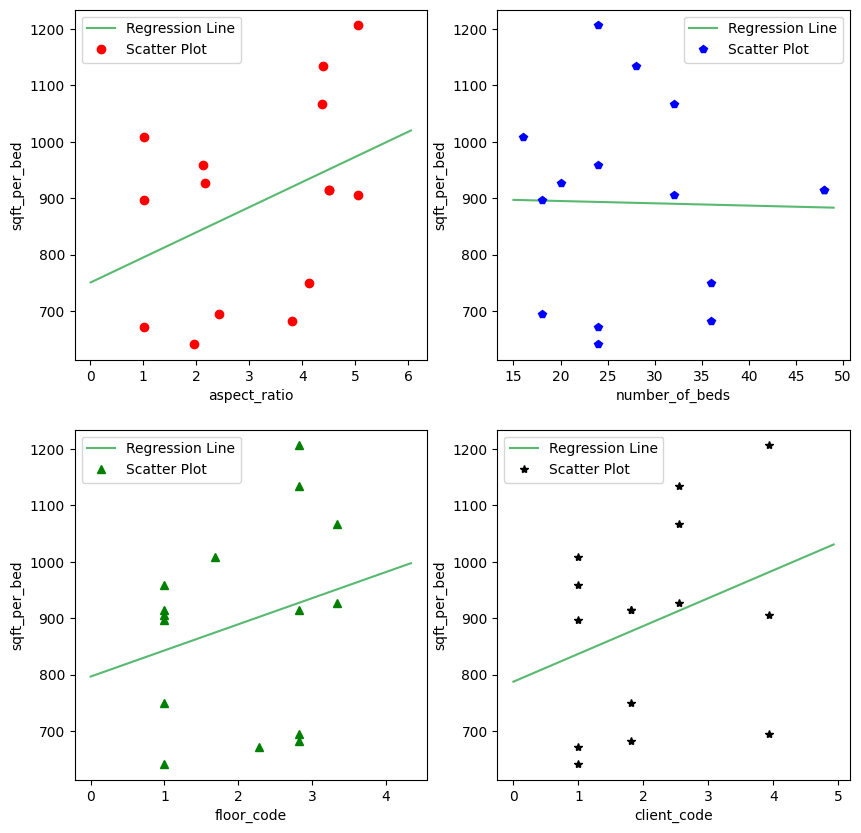

In [16]:
import matplotlib.pyplot as plt 
max_x1 = np.max(X1) + 1
min_x1 = np.min(X1) - 1
x1 = np.linspace(min_x1, max_x1, 1000)
max_x2 = np.max(X2) + 1
min_x2 = np.min(X2) - 1
x2 = np.linspace(min_x2, max_x2, 1000)
max_x3 = np.max(X3) + 1
min_x3 = np.min(X3) - 1
x3 = np.linspace(min_x3, max_x3, 1000)
max_x4 = np.max(X4) + 1
min_x4 = np.min(X4) - 1
x4 = np.linspace(min_x4, max_x4, 1000)
y1 = c1 + m1 * x1
y2 = c2 + m2 * x2
y3 = c3 + m3 * x3
y4 = c4 + m4 * x4

plt.figure().set_size_inches(10,10)
plt.subplot(221)
plt.plot(x1, y1, color='#58b970', label='Regression Line')
plt.plot(X1, Y, 'ro', label='Scatter Plot') 
plt.xlabel('aspect_ratio')
plt.ylabel('sqft_per_bed')
plt.legend()
plt.subplot(222)
plt.plot(x2, y2, color='#58b970', label='Regression Line')
plt.plot(X2, Y,'bp', label='Scatter Plot') 
plt.xlabel('number_of_beds')
plt.ylabel('sqft_per_bed')
plt.legend()
plt.subplot(223)
plt.plot(x3, y3, color='#58b970', label='Regression Line')
plt.plot(X3, Y, 'g^', label='Scatter Plot') 
plt.xlabel('floor_code')
plt.ylabel('sqft_per_bed')
plt.legend()
plt.subplot(224)
plt.plot(x4, y4, color='#58b970', label='Regression Line')
plt.plot(X4, Y, 'k*', label='Scatter Plot') 
plt.xlabel('client_code')
plt.ylabel('sqft_per_bed')
plt.legend()
plt.show()